In [13]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm
from sklearn.datasets import make_swiss_roll

In [3]:
print(make_swiss_roll.__doc__)

Generate a swiss roll dataset.

    Read more in the :ref:`User Guide <sample_generators>`.

    Parameters
    ----------
    n_samples : int, default=100
        The number of sample points on the Swiss Roll.

    noise : float, default=0.0
        The standard deviation of the gaussian noise.

    random_state : int, RandomState instance or None, default=None
        Determines random number generation for dataset creation. Pass an int
        for reproducible output across multiple function calls.
        See :term:`Glossary <random_state>`.

    hole : bool, default=False
        If True generates the swiss roll with hole dataset.

    Returns
    -------
    X : ndarray of shape (n_samples, 3)
        The points.

    t : ndarray of shape (n_samples,)
        The univariate position of the sample according to the main dimension
        of the points in the manifold.

    Notes
    -----
    The algorithm is from Marsland [1].

    References
    ----------
    .. [1] S. Marsland,

In [14]:
def sample_batch(batch_size, device='cpu'):
    data,_=make_swiss_roll(batch_size)
    data=data[:,[2,0]]/10
    data=data*np.array([1,-1])
    return torch.from_numpy(data)

In [15]:
class MLP(nn.Module):

    def __init__(self, N=40, data_dim=2, hidden_dim=64):
        super(MLP, self).__init__()

        self.network_head = nn.Sequential(nn.Linear(data_dim, hidden_dim),
                                          nn.ReLU(),
                                          nn.Linear(hidden_dim, hidden_dim),
                                          nn.ReLU(),)

        self.network_tail = nn.ModuleList([nn.Sequential(nn.Linear(hidden_dim, hidden_dim),
                                                         nn.ReLU(),
                                                         nn.Linear(hidden_dim, data_dim * 2),) for t in range(N)])

    def forward(self, x, t):

        h = self.network_head(x) # [batch_size, hidden_dim]
        tmp = self.network_tail[t](h) # [batch_size, data_dim * 2]
        mu, h = torch.chunk(tmp, 2, dim=1)
        var = torch.exp(h)
        std = torch.sqrt(var)

        return mu, std



In [16]:
class DiffusionModel():

    def __init__(self, T, model: nn.Module, device, dim=2):

        self.betas = (torch.sigmoid(torch.linspace(-18, 10, T)) * (3e-1 - 1e-5) + 1e-5).to(device)
        self.alphas = 1 - self.betas
        self.alphas_bar = torch.cumprod(self.alphas, 0)

        self.T = T
        self.model = model
        self.dim = dim

    def forward_process(self, x0, t):
        """
        :param t: Number of diffusion steps
        """

        assert t > 0, 't should be greater than 0'
        assert self.T <= self.T, f't should be lower or equal than {self.T}'

        t = t - 1 # Because we start indexing at 0

        mu = torch.sqrt(self.alphas_bar[t]) * x0
        std = torch.sqrt(1 - self.alphas_bar[t])
        epsilon = torch.randn_like(x0)
        xt = mu + epsilon * std # data ~ N(mu, std)


        std_q = torch.sqrt((1 - self.alphas_bar[t-1])/ (1 - self.alphas_bar[t]) * self.betas[t])
        m1 = torch.sqrt(self.alphas_bar[t-1]) * self.betas[t] / (1 - self.alphas_bar[t])
        m2 = torch.sqrt(self.alphas[t]) * (1 - self.alphas_bar[t-1]) / (1 - self.alphas_bar[t])
        mu_q = m1 * x0 + m2 * xt

        return mu_q, std_q, xt

    def reverse_process(self, xt, t):
        """
        :param t: Number of diffusion steps
        """

        assert t > 0, 't should be greater than 0'
        assert self.T <= self.T, f't should be lower or equal than {self.T}'

        t = t - 1 # Because we start indexing at 0

        mu, std = self.model(xt, t)
        epsilon = torch.randn_like(xt)

        return mu, std, mu + epsilon * std # data ~ N(mu, std)


    def sample(self, batch_size, device):

        noise = torch.randn((batch_size, self.dim)).to(device)
        x = noise

        samples = [x]
        for t in range(self.T, 0, -1):

            if not (t == 1):
                _, _, x = self.reverse_process(x, t)

            samples.append(x)

        return samples[::-1]


    def get_loss(self, x0):
        """
        :param x0: batch [batch_size, self.dim]
        """

        t = torch.randint(2, 40+1, (1,))
        mu_q, sigma_q, xt = self.forward_process(x0, t)

        mu_p, sigma_p, xt_minus1 = self.reverse_process(xt.float(), t)

        KL = torch.log(sigma_p) - torch.log(sigma_q) + (
            sigma_q**2 + (mu_q - mu_p)**2) / (2 * sigma_p**2)
        K = - KL.mean() # Should be maximized
        loss = - K # Should be minimized

        return loss


In [17]:
def plot(model, file_name, device):

    fontsize = 14
    fig = plt.figure(figsize=(10, 6))

    N = 5_000
    x0 = sample_batch(N).to(device)
    samples = model.sample(N, device=device)

    data = [x0.cpu(), model.forward_process(x0, 20)[-1].cpu(), model.forward_process(x0, 40)[-1].cpu()]
    for i in range(3):

        plt.subplot(2, 3, 1+i)
        plt.scatter(data[i][:, 0].data.numpy(), data[i][:, 1].data.numpy(), alpha=0.1, s=1)
        plt.xlim([-2, 2])
        plt.ylim([-2, 2])
        plt.gca().set_aspect('equal')

        if i == 0: plt.ylabel(r'$q(\mathbf{x}^{(0..T)})$', fontsize=fontsize)
        if i == 0: plt.title(r'$t=0$', fontsize=fontsize)
        if i == 1: plt.title(r'$t=\frac{T}{2}$', fontsize=fontsize)
        if i == 2: plt.title(r'$t=T$', fontsize=fontsize)

    time_steps = [0, 20, 40]
    for i in range(3):

        plt.subplot(2, 3, 4+i)
        plt.scatter(samples[time_steps[i]][:, 0].data.cpu().numpy(), samples[time_steps[i]][:, 1].data.cpu().numpy(),
                    alpha=0.1, c='r', s=1)
        plt.xlim([-2, 2])
        plt.ylim([-2, 2])
        plt.gca().set_aspect('equal')

        if i == 0: plt.ylabel(r'$p(\mathbf{x}^{(0..T)})$', fontsize=fontsize)

    plt.savefig(file_name, bbox_inches='tight')
    plt.close()

In [ ]:
def train(diffusion_model, optimizer, batch_size, nb_epochs, device):

    training_loss = []
    for epoch in tqdm(range(nb_epochs)):
        x0 = sample_batch(batch_size).to(device)
        loss = diffusion_model.get_loss(x0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        training_loss.append(loss.item())

        if epoch % 5000 == 0:
            plt.plot(training_loss)
            plt.savefig(f'figs/training_loss_epoch_{epoch}.png')
            plt.close()

            plot(diffusion_model, f'figs/training_epoch_{epoch}.png', device)

    return training_loss

device = 'cpu'
mlp_model = MLP(hidden_dim=128).to(device)
model = DiffusionModel(40, mlp_model, device)
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=1e-4)

train(model, optimizer, 64_000, 300_000, device)

 15%|█▍        | 44749/300000 [5:00:16<30:26:54,  2.33it/s]

In [174]:
# def forward_process(data,T,betas):

#     for t in range(T):
#         beta_t=betas[t]
#         mu=data *torch.sqrt(1-beta_t)
#         std=np.sqrt(beta_t)
#         # Sample from q(x_t|x_{t-1})
#         data=mu+ torch.rand_like(data) * std # data ~ N(mu,std)
#     return data

In [175]:
print(xT.mean(0))
print(xT.std(0))

tensor([ 0.0316, -0.2189], dtype=torch.float64)
tensor([0.6975, 0.6565], dtype=torch.float64)


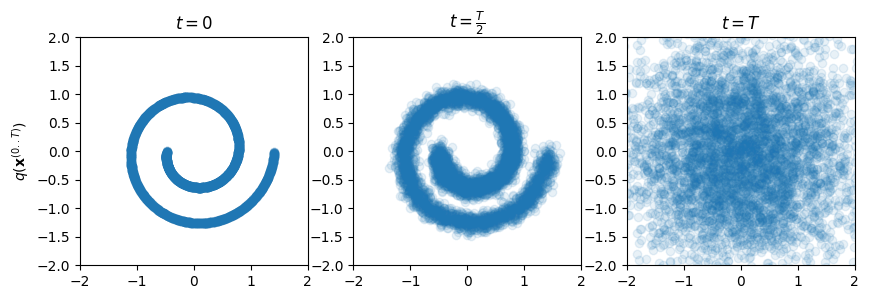

In [176]:
fig=plt.figure(figsize=(10,3))

data=[x0,model.forward_process(x0,20),model.forward_process(x0,40)]
for i in range(3):
    plt.subplot(1,3,1+i)
    plt.scatter(data[i][:,0].data.numpy(),data[i][:,1].data.numpy(),alpha=0.1)
    plt.xlim([-2,2])
    plt.ylim([-2,2])
    plt.gca().set_aspect('equal')

    if i==0: plt.ylabel(r'$q(\mathbf{x}^{(0..T)})$')
    if i==0: plt.title(r'$t=0$')
    if i==1: plt.title(r'$t=\frac{T}{2}$')
    if i==2: plt.title(r'$t=T$')


##**Training Equations**